In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point

import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime
import pylab as pl
import os
from IPython import display
from subprocess import call
import subprocess
import sys
sys.path.append(r'C:\Users\Patrick\Documents\GitHub\PatchSim')
import patchsim as sim
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import io

%matplotlib inline





In [3]:
stages = 6
sc = 'a' # sc='a' for baseline, sc='b' for pull-out

for s in range(stages):
    if s!=3:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}.txt'.format(s)),write_epi=True)
    else:
        sim.run_disease_simulation(sim.read_config('../data/patchsim/cfg_stage{}{}.txt'.format(s,sc)),write_epi=True)

out_df = pd.DataFrame()
for s in range(stages):
    if s!=3:
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)
    else:
        temp_df = pd.read_csv('../outputs/sample{}{}.out'.format(s,sc),delimiter=' ',header=None,index_col=0)
        
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)

In [4]:
evd_df = pd.read_csv('..\data\Ebola_Updated_Feb03.csv', delimiter='\t')
evd_df['Date'] = evd_df.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt = evd_df[evd_df.health_zone=='all'].total_c.values
evd_df=evd_df.drop('total_cure', axis=1)
evd_df['all_cases'] = evd_df['total_c'] + evd_df['total_p'] + evd_df['total_s']
evd_df['health_zone'] = evd_df['health_zone'].str.upper()
evd_df=evd_df[evd_df['province']=='North-Kivu'].reset_index().drop('index', axis=1)

In [5]:
evd_df.head()


,date,province,health_zone,total_p,total_c,new_s,total_s,total_d,total_dc,total_vacc,Date,all_cases
0,20180728,North-Kivu,ALIMBONGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,NaN
1,20180728,North-Kivu,BENI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,NaN
2,20180728,North-Kivu,BIENA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,NaN
3,20180728,North-Kivu,BUTEMBO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,NaN
4,20180728,North-Kivu,GOMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,NaN


In [6]:
gdfF = gpd.read_file('../data/shapefile/healthzones_v2/DRC_Districts.shp')
north_kivu= gdfF[gdfF['ADM1_NAME']=='NORD KIVU']
gdf=north_kivu
gdf= gdf.rename(columns={'ADM1_NAME': 'province', 'ADM2_NAME': 'health_zone'})
gdf['province']='North-Kivu'
gdf.head()

,health_zone,province,CENTER_LON,CENTER_LAT,geometry
1,ALIMBONGO,North-Kivu,28.956674,-0.234287,POLYGON ((28.8687262120001 -0.0804889769999591...
2,KAYNA,North-Kivu,28.950392,-0.471119,"POLYGON ((29.3267510950001 -0.478486977999978,..."
3,KIBIRIZI,North-Kivu,29.214037,-0.831976,"POLYGON ((29.4475984700001 -0.601324727999952,..."
4,KYONDO,North-Kivu,29.488140,0.003681,"POLYGON ((29.6337365160001 0.195795345000022, ..."
5,LUBERO,North-Kivu,29.354030,-0.255992,"POLYGON ((29.262692337 -0.101676476999955, 29...."


In [7]:
p=gdfF = gpd.read_file('../data/shapefile/healthzones_v1/zone_stc_puc.shp')
NK= p[p['PROVINCE']=='Nord Kivu']
NK.head()

,ID,PAYS,PROVINCE,CPROV_SNIS,DIST_ADM,CDA_SNIS,TERRITOIRE,CTER_SNIS,DIST_SA,NOM_ZS,CZS_SNIS,SCE_GEO,Cde_ZS_PUC,Cde_DS_PUC,Nom_DS_PUC,Nom_ZS_PUC,Area,Pop,geometry
48,0,RDC,Nord Kivu,08,Rutshuru,0804,Goma,080401,Goma,Goma,08040101,Div_snis,08040101,None,Rutshuru,Goma,45.445281,NaN,POLYGON ((3245311.612300013 -178095.9895000016...
49,0,RDC,Nord Kivu,08,Rutshuru,0804,Karisimbi,080402,Goma,Karisimbi,08040201,Div_snis,08040201,None,Rutshuru,Karisimbi,443.883990,NaN,POLYGON ((3258049.484100002 -162602.5025000023...
50,0,RDC,Nord Kivu,08,Rutshuru,0804,Rushuru,080404,Goma,Binza,08040402,Div_snis,08040402,None,Rutshuru,Binza,1263.830911,NaN,POLYGON ((3300729.156500001 -51188.13109999501...
51,0,RDC,Nord Kivu,08,Butembo,0802,Lubero,080203,Butembo,Manguredjipa,08020305,Div_snis,08020305,None,Butembo,Manguredjipa,5609.409484,NaN,"POLYGON ((3228609.575399999 47233.03409999882,..."
52,0,RDC,Nord Kivu,08,Rutshuru,0804,Rushuru,080404,Goma,Birambizo,08040403,Div_snis,08040403,None,Rutshuru,Birambizo,1708.193261,NaN,"POLYGON ((3251435.416862256 -78539.6945107505,..."


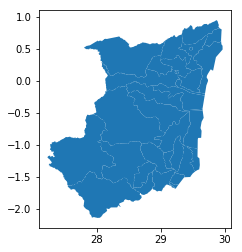

In [8]:
gdf.plot()


In [9]:
temp_gdf = pd.merge(evd_df, gdf, how="left", on="health_zone").dropna().reset_index()
temp_gdf=temp_gdf.drop('index', axis=1)
temp_gdf= gpd.GeoDataFrame(temp_gdf, geometry='geometry')

temp_gdf.head()

,date,province_x,health_zone,total_p,total_c,new_s,total_s,total_d,total_dc,total_vacc,Date,all_cases,province_y,CENTER_LON,CENTER_LAT,geometry
0,20180815,North-Kivu,BENI,0.0,5.0,2.0,8.0,4.0,4.0,100.0,2018-08-15,13.0,North-Kivu,29.469531,0.499516,"POLYGON ((29.4753832710001 0.475662641000042, ..."
1,20180815,North-Kivu,MABALAKO,21.0,39.0,4.0,6.0,33.0,12.0,176.0,2018-08-15,66.0,North-Kivu,29.214418,0.486209,"POLYGON ((29.344317146 0.599678266000069, 29.3..."
2,20180818,North-Kivu,BENI,0.0,5.0,2.0,3.0,3.0,3.0,256.0,2018-08-18,8.0,North-Kivu,29.469531,0.499516,"POLYGON ((29.4753832710001 0.475662641000042, ..."
3,20180818,North-Kivu,MABALAKO,21.0,52.0,5.0,5.0,40.0,19.0,467.0,2018-08-18,78.0,North-Kivu,29.214418,0.486209,"POLYGON ((29.344317146 0.599678266000069, 29.3..."
4,20180819,North-Kivu,BENI,0.0,5.0,2.0,2.0,3.0,3.0,367.0,2018-08-19,7.0,North-Kivu,29.469531,0.499516,"POLYGON ((29.4753832710001 0.475662641000042, ..."


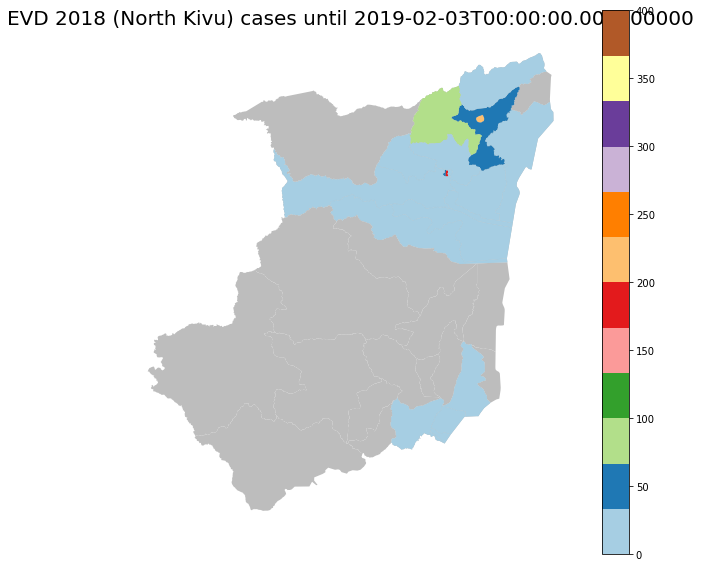

In [11]:
count = 0
for rd in evd_df.Date.unique():
    f = plt.figure(figsize=(10,10))
    ax = plt.gca()
    plt.axis('off')
    plt.title('EVD 2018 (North Kivu) cases until {}'.format(rd),fontsize=20)
    gdf.plot(color='#bdbdbd',ax=ax)
    df = evd_df[evd_df.Date==rd]
    temp_gdf = gdf.merge(df,left_on='health_zone',right_on='health_zone',how='inner')
    temp_gdf.plot(ax=ax,column='total_c',cmap='Paired',vmin=0,vmax=400,legend=True)
    display.clear_output(wait=True)
    display.display(pl.gcf())    
    plt.savefig('../plots/Ebola_NKmovie_Feb03/{:003d}.png'.format(count),bbox_inches='tight')
    count+=1
    plt.close()
call("magick convert -delay 40 -loop 1 ../plots/*.png ../plots/Ebola_NKmovie_Feb03/animated_NK_Feb03.gif".split(' '))
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];


In [ ]:
[os.remove('../plots/'+x) for x in os.listdir('../plots') if '.png' in x];